In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 89%|██████████████████████████████████▉    | 23.0M/25.7M [00:00<00:00, 116MB/s]
100%|███████████████████████████████████████| 25.7M/25.7M [00:00<00:00, 121MB/s]


In [3]:
from zipfile import ZipFile

In [4]:
with ZipFile('/kaggle/working/imdb-dataset-of-50k-movie-reviews.zip', 'r') as zipref:
    zipref.extractall()

In [5]:
import pandas as pd
import numpy as np
import tensorflow.keras as tf

In [6]:
dataset = pd.read_csv('/kaggle/working/IMDB Dataset.csv')
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
dataset['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [9]:
dataset['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [10]:
dataset['target'] = dataset['sentiment'].map({'positive' : 1, 'negative' : 0})

In [11]:
dataset.head()

,review,sentiment,target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [12]:
texts = [review for review in dataset['review']]

In [13]:
texts[:3]

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
tokenizer = Tokenizer(num_words = 10_000)

In [16]:
tokenizer.fit_on_texts(texts)

In [17]:
len(tokenizer.word_index)

124252

In [18]:
sequences = tokenizer.texts_to_sequences(texts)

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
max_len = 600

In [21]:
x = pad_sequences(sequences, maxlen = max_len)

In [22]:
x[:3]

array([[   0,    0,    0, ...,  125, 4103,  486],
       [   0,    0,    0, ..., 1977,   69,  221],
       [   0,    0,    0, ...,   63,   16,  350]], dtype=int32)

In [23]:
from tensorflow.keras.layers import (Input, 
                                     Dense,
                                     Embedding,
                                     MultiHeadAttention, 
                                     LayerNormalization, 
                                     Dropout,
                                     GlobalAveragePooling1D
                                    )
from tensorflow.keras.models import Model

In [24]:
def build_model(embedding_dim, vocab_size, max_len, num_heads, ff_dim):
    
    inputs = Input(shape = (max_len,))
    
    # Embedding Layer
    embedding_layer = Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_len)(inputs)
    
    # Query, Key, Value from the Embedding Layer
    query = Dense(embedding_dim)(embedding_layer)
    key = Dense(embedding_dim)(embedding_layer)
    value = Dense(embedding_dim)(embedding_layer)
    
    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads = num_heads, key_dim = embedding_dim)(query, key, value)
    
    # Add & Norm
    attention_output = LayerNormalization(epsilon = 1e-6)(attention_output + embedding_layer)
    
    # Feed-Forward Network
    ff_output = Dense(ff_dim, activation = 'relu')(attention_output)
    ff_output = Dense(embedding_dim)(ff_output)
    
    # Add & Norm
    ff_output = LayerNormalization(epsilon = 1e-6)(attention_output + ff_output)
    
    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(ff_output)
    
    # Final Classification head
    dense_output = Dense(32, activation = 'relu')(pooled_output)
    final_output = Dense(1, activation = 'sigmoid')(dense_output)
    
    model = Model(inputs = inputs, outputs = final_output)
    
    return model

In [31]:
vocab_size = 10_000
embedding_dim = 64
max_len = 600
num_heads = 4
ff_dim = 128

model = build_model(embedding_dim, vocab_size, max_len, num_heads, ff_dim)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 600, 64)   │    640,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 600, 64)   │      4,160 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 600, 64)   │      4,160 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 600, 64)   │      4,160 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 600, 64)   │     66,368 │ dense_7[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_8[0][0],    │
│                     │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 600, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 600, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 600, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 600, 64)   │      8,256 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 600, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 600, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         33 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 737,793 (2.81 MB)

 Trainable params: 737,793 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from tensorflow.keras.utils import plot_model

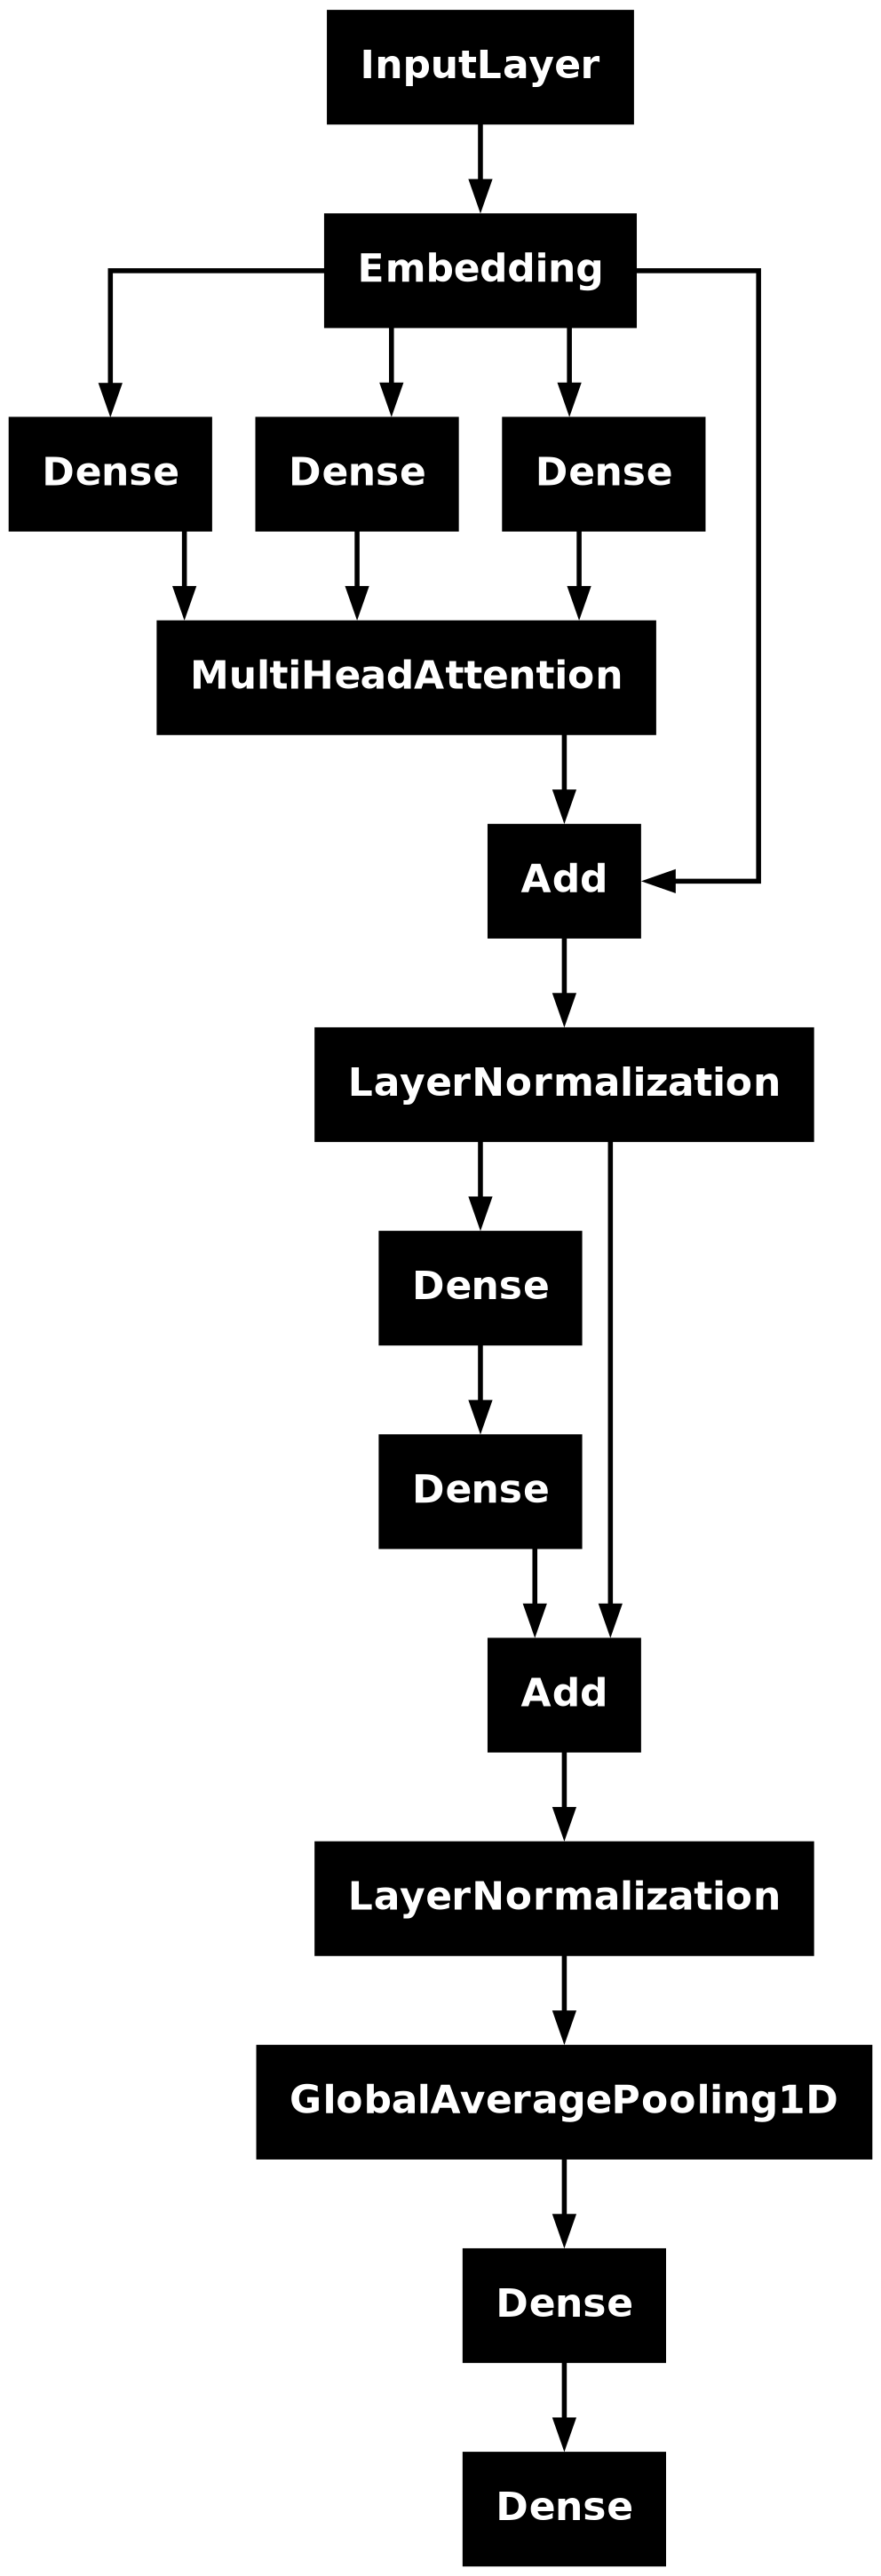

In [33]:
plot_model(model)

In [34]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [35]:
model.fit(x, dataset['target'], epochs = 5, batch_size = 2, validation_split = 0.2)

Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 96s 4ms/step - accuracy: 0.8087 - loss: 0.4062 - val_accuracy: 0.8886 - val_loss: 0.2852
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - accuracy: 0.9125 - loss: 0.2354 - val_accuracy: 0.8908 - val_loss: 0.2814
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - accuracy: 0.9265 - loss: 0.1952 - val_accuracy: 0.8935 - val_loss: 0.2719
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - accuracy: 0.9373 - loss: 0.1760 - val_accuracy: 0.8741 - val_loss: 0.3248
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - accuracy: 0.8851 - loss: 0.2850 - val_accuracy: 0.7812 - val_loss: 0.4898


In [67]:
text = ["The movie was absolutely amazing, with stunning visuals and a gripping plot."
"I didn't enjoy the food at the restaurant; the service was slow, and the dishes were bland."
"The new smartphone has excellent battery life and a sleek design."
"This book is a must-read for anyone interested in historical fiction.",
"The weather today is terrible, with heavy rain and strong winds.",
"I found the software to be user-friendly and efficient.",
"The customer support team was unhelpful and rude.",
"This place is perfect for a relaxing weekend getaway.",
"I had a great experience shopping at this store.",
"The laptop overheats quickly and has poor performance."]

s = tokenizer.texts_to_sequences(texts)
p = pad_sequences(s, maxlen = max_len)

prediction = model.predict(p)
for pred in prediction:
    if pred > 0.5:
        print('positive')
    else: 
        print('negative')

I0000 00:00:1724924922.010838     996 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_14', 8 bytes spill stores, 8 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
positive
negative
positive
positive
negative
positive
negative
positive
positive
negative
positive
negative
positive
positive
positive
positive
positive
positive
positive
positive
negative
positive
positive
positive
negative
positive
negative
positive
negative
positive
negative
positive
negative
positive
positive
negative
positive
positive
negative
negative
positive
positive
positive
negative
positive
positive
positive
negative
positive
positive
positive
negative
positive
positive
positive
negative
negative
negative
positive
negative
positive
positive
positive
positive
positive
positive
negative
negative
negative
positive
negative
positive
negative
negative
negative
positive
negative
negative
positive
positive
positive
positive
negative
positive
positive
negative
positive
positive
positive
positive
negative
positive
positive
positive
negative
positive
positive
positive
positive
positive
negative
positive
positive


In [1]:
prediction

NameError: name 'prediction' is not defined